In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Step 1: Define Attention Block
def attention_block(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(inputs.shape[-1] // 8, activation='relu')(x)
    x = Dense(inputs.shape[-1], activation='sigmoid')(x)
    x = Reshape((1, 1, inputs.shape[-1]))(x)
    return Multiply()([inputs, x])

# Step 2: Build Attention CNN Model
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = attention_block(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Step 3: Data Setup
image_size = 224
batch_size = 32

# ✅ FIXED PATH: Go directly into the folder with only 'yes' and 'no'
data_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")

# Step 4: Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# ✅ Print to confirm correct labels
print("Class indices:", train_generator.class_indices)

# Step 5: Build and Train Model
num_classes = len(train_generator.class_indices)
model = build_model((image_size, image_size, 3), num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=10, validation_data=val_generator)

# Step 6: Save model
model.save("brain_tumor_model.h5")

def predict_image(img_path):
    img = Image.open(img_path).resize((image_size, image_size)).convert("RGB")
    img_array = np.array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class probabilities
    prediction = model.predict(img_array)[0]

    # Get class indices and order the class names correctly
    class_indices = train_generator.class_indices
    class_names = [None] * len(class_indices)
    
    # Assign class names correctly based on indices
    for cls, idx in class_indices.items():
        class_names[idx] = cls

    # Here class_names will be in the correct order
    predicted_class = class_names[np.argmax(prediction)]
    
    # Show prediction confidence
    confidence = np.max(prediction) * 100

    # Modify the title to show "Yes: Brain Tumor" or "No: Brain Tumor"
    if predicted_class == 'yes':
        predicted_class_label = "Yes - Brain Tumor"
    elif predicted_class == 'no':
        predicted_class_label = "Normal"
    else:
        predicted_class_label = predicted_class

    # Plot the image and prediction with confidence score
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


# Test the prediction function with an image path
# predict_image("/path/to/test_image.jpg")


# Example:
# predict_image("/kaggle/working/test_image.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


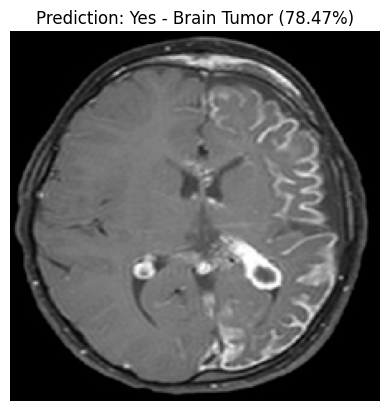

In [8]:
predict_image("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y186.jpg")